In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit
import astropy
import astropy.units as u
import corner

In [44]:
from scipy import integrate

In [65]:
def DM(z,H0,Om,w0,w1):
    c=299792.
   # quad only accepts scalars, so need to use a list comprehension to run through the whole array of z
    Ezz = lambda zz: (np.sqrt((Om*(1+zz)**3.)+((1-Om)*(1+zz)**(3.*(1.+w0+w1))*np.exp((-3.*w1*zz)/(1+zz)))))**(-1)
    #Ez=[j**(-1) for j in Ezz()]
    #x1 = [j**2 for j in x]
    DT=[integrate.quadrature(Ezz, 0, zi) for zi in z]
    # Returns a list, so we convert to a numpy array
    DL1=np.array(DT)
    a=[1e6*(c*(1+zi)/H0)for zi in z]
    a1=np.array(a)
    a2 = a1.reshape(-1, 1)
    DL=a2*DL1
    mag=5*np.log10(DL[:,0]/10)
    return mag

In [66]:
zs= np.linspace(0.01, 5., num=1000)

In [67]:
#From Planck observations for CPL mode
O_m=0.3029
w_0=-0.9414
w_1=-0.4303
H_0=68.5265

In [68]:
#print DM(zs,70.,0.2855,-1.17,0.35)

In [69]:
mm=DM(zs,H_0,O_m,w_0,w_1)

In [70]:
print mm

[33.22082264 34.1084786  34.74068456 35.23284257 35.6363803  35.97873862
 36.2763004  36.53963446 36.77595794 36.990419   37.1868192  37.36804571
 37.53634293 37.69349021 37.84092208 37.97981198 38.11113204 38.23569662
 38.35419475 38.4672146  38.57526224 38.67877626 38.77813929 38.87368708
 38.96571594 39.05448861 39.14023921 39.22317724 39.3034909  39.3813499
 39.45690783 39.5303041  39.60166566 39.67110844 39.73873861 39.80465361
 39.86894311 39.93168983 39.99297019 40.05285499 40.11140993 40.16869608
 40.22477031 40.27968569 40.33349179 40.38623499 40.43795878 40.48870395
 40.53850884 40.58740953 40.63544001 40.68263232 40.72901675 40.77462191
 40.81947487 40.8636013  40.90702552 40.94977062 40.99185853 41.03331012
 41.07414523 41.11438277 41.15404076 41.1931364  41.2316861  41.26970554
 41.30720972 41.34421298 41.38072907 41.41677112 41.45235177 41.48748311
 41.52217675 41.55644384 41.5902951  41.62374083 41.65679095 41.68945498
 41.72174212 41.75366121 41.78522079 41.81642907 41.

In [71]:
e = np.random.normal(0., 0.3, 1000)

In [72]:
dist_mod=mm + e

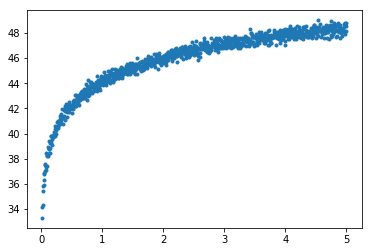

In [73]:
plt.plot(zs,dist_mod, '.')

In [74]:
d = {'redshift': zs, 'distance_mod': dist_mod,'DM_err':e}

In [75]:
df = pd.DataFrame(data=d)

In [76]:
dat=np.sort(df.T, axis=0)
zz1 = df.redshift
dm = df.distance_mod
edm =df.DM_err

In [77]:
from astropy.cosmology import w0waCDM

In [78]:
def DM1(z1,H01,Om1,Ode1,w01,wa1):
    cosmo = w0waCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,Ode0=Ode1,w0=w01,wa=wa1)
    Dl=cosmo.luminosity_distance(z1)
    mag1=5*np.log10((Dl/(10*u.pc)).decompose())
    return mag1

In [79]:
p = lmfit.Parameters()
p.add_many(('Om1',0.3,True,0.,2.),('H01',70.0,True,50.,100.),('Ode1',0.7,True,0.,2.),('w01',-1.0,True,-2.,2.),('wa1',-0.1,True,-1.,1.))

def residual(p):
    v = p.valuesdict()
    return (DM1(zz1,v['H01'],v['Om1'],v['Ode1'],v['w01'],v['wa1'])-dm)/edm

In [80]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [81]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 561
    # data points      = 1000
    # variables        = 5
    chi-square         = 991.583523
    reduced chi-square = 0.99656635
    Akaike info crit   = 1.54790440
    Bayesian info crit = 26.0866808
[[Variables]]
    Om1:   0.28912114 (init = 0.3)
    H01:   67.9361173 (init = 70)
    Ode1:  0.73647793 (init = 0.7)
    w01:  -0.86860370 (init = -1)
    wa1:  -0.22017803 (init = -0.1)


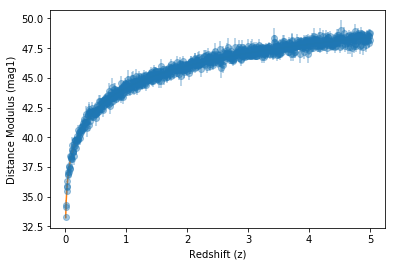

In [82]:
s = (zz1.sort_values()).index
plt.errorbar(zz1[s],dm[s],yerr=edm[s],fmt='o',alpha=0.4)
bestOm1 = mi.params.valuesdict()['Om1']
bestH01 = mi.params.valuesdict()['H01']
bestOde1= mi.params.valuesdict()['Ode1']
bestw01 = mi.params.valuesdict()['w01']
bestwa1 = mi.params.valuesdict()['wa1']
plt.plot(zz1[s],DM1(zz1[s],bestH01,bestOm1,bestOde1,bestw01,bestwa1))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mag1)')
lmfit.report_fit(mi)

In [83]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500, thin=1,
                         params=p, is_weighted=True)

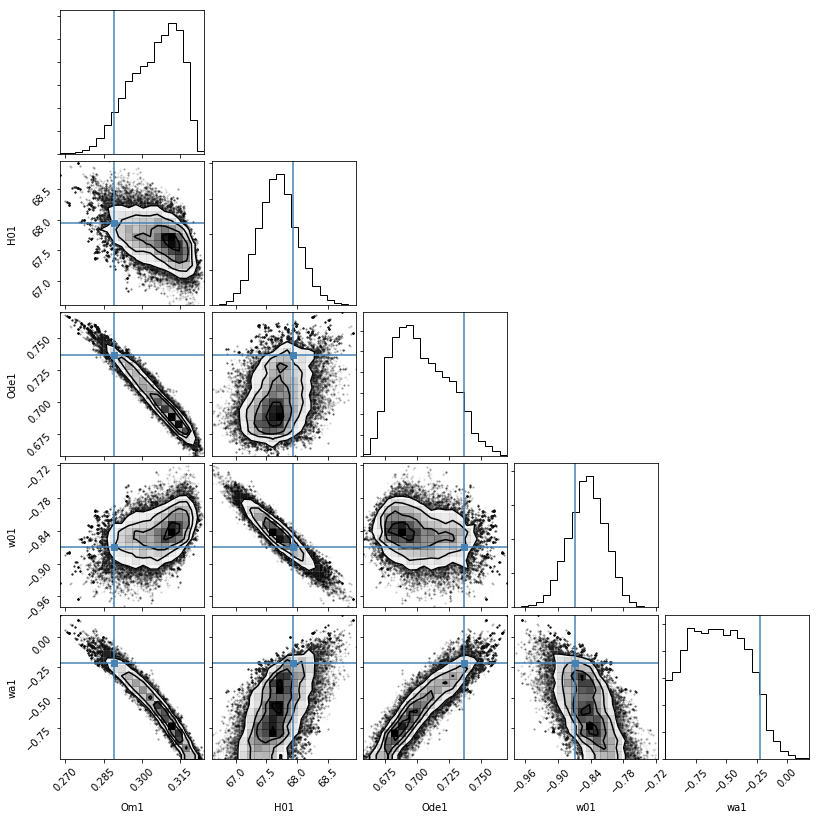

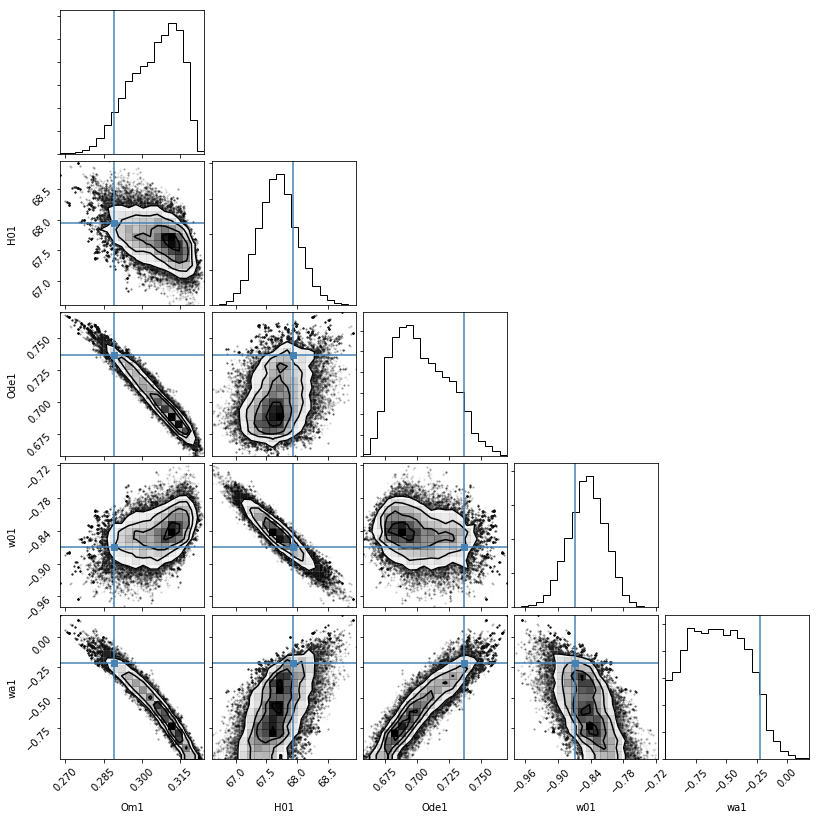

In [84]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))